In [ ]:
#런타임 GPU로
# mnist


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision # 영상처리 라이브러리
from torchvision import transforms, datasets

%matplotlib inline

In [ ]:
 #gpu 쓸 수 있는지 확인

if torch.cuda.is_available():
        DEVICE = torch.device('cuda:0')

else:
    DEVICE = torch.device('cpu')

print(DEVICE) #이걸 DEVICE에 저장했다.

cuda:0


In [ ]:
train_dataset = datasets.MNIST(
    root = '../data/MNIST', #위 MNIST를 data폴더에 MNIST폴더에 저장해라.
    train = True,  #학습 데이터(학습 한다.)
    download = True, #다운로드 받겠다.
    transform = transforms.ToTensor() # 데이터 전처리(텐서 형태로)

)

test_dataset = datasets.MNIST(
    root = '../data/MNIST', #위 MNIST를 data폴더에 MNIST폴더에 저장해라.
    train = False,  #테스트 데이터
    download = True, #다운로드 받겠다.
    transform = transforms.ToTensor() # 데이터 전처리(텐서 형태로)

)

## 데이터 폴더 생긴 것 확인.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, #사용할 데이터(위에서 만들어 준 train_dataset)
    batch_size = BATCH_SIZE, #몇개씩 짤라서 넣자(batch)
    shuffle = True  #데이터 섞을 것다.(무작위로 뽑아서 넣을 거다.)
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, #사용할 데이터(위에서 만들어 준 test_dataset)
    batch_size = BATCH_SIZE, #몇개씩 짤라서 넣자(batch)
    shuffle =  False #데이터 안 섞을 거다.
)


### 이터레이터 성격을 띔(반복문 같은 느낌)

In [ ]:
images, labels = next(iter(train_loader)) #이터레이터 성격 띄는지 확인 방법.

print(images.size(), images.type()) #세로크기 28, 가로크기 28 픽셀. 그림 하나가 1*28*28형태에서 그런게 32개
print(labels.size(), images.type()) #그게 32개가 있다.

torch.Size([32, 1, 28, 28]) torch.FloatTensor
torch.Size([32]) torch.FloatTensor


Text(0.5, 1.0, '8')

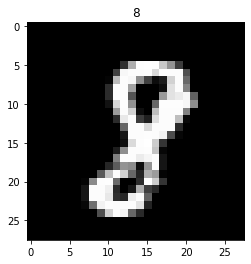

In [ ]:
img = np.squeeze(images[7].numpy()) #images의 7번째 인덱스. 위의 1 값을 squeeze로 없앤다.([1*28*28]배열을 28*28배열로.)

#plt는 numpy 밖에 인식 못함.
plt.imshow(img, cmap  = 'gray')
plt.title(str(labels[7].item()))

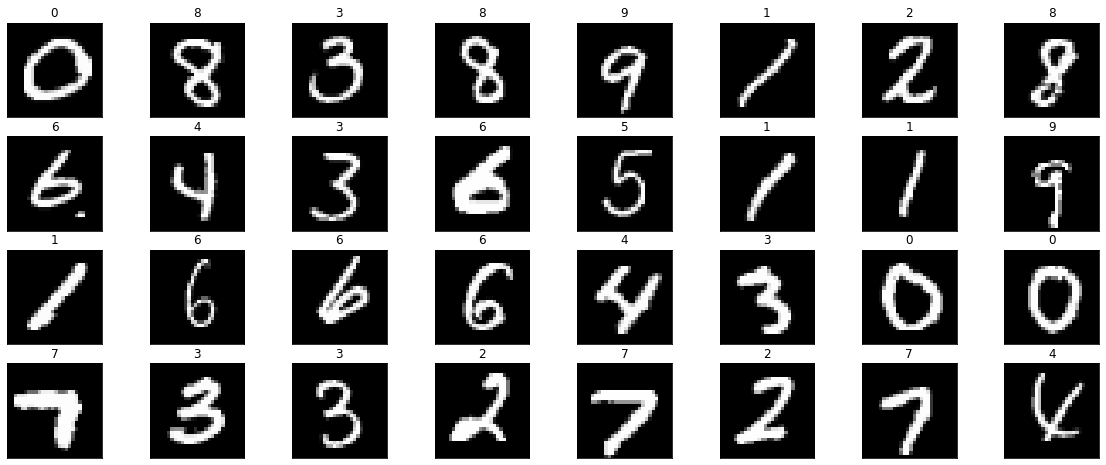

In [ ]:
####### 재확인.

fig = plt.figure(figsize = (20,8))

for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, int(BATCH_SIZE / 4), idx + 1, xticks = [], yticks = []) ## 4* (BATCH_SIZE /4) 크기의 subploit생성. idx + 1 번째 subplot
    ## y축 4, x축 8
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
    ax.set_title(str(labels[idx].item())) #set_title로 제목 적기.

In [ ]:
#그림 그리는 다른 방식.

def imshow(img):
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0))) ##npimg의 차원, 높이1, 너비2, 채널0으로 변경.
    plt.show()

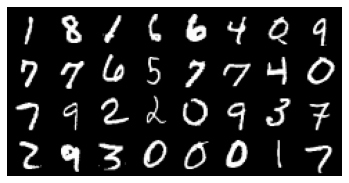

In [ ]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
###########

In [ ]:
npimg = torchvision.utils.make_grid(images).numpy() ##images에 담긴것, grid형태로 변환하고 numpy로.
# 아까 넘파이 배열로 바꿔준 것.기울기 켜주고 다시 넘파이.

npimg.shape

(3, 122, 242)

In [ ]:
########### 확인.



class MLP(nn.Module): ## MLP는 3개의 fully connected layer로 구성.
    def __init__(self):
        super(MLP, self).__init__() #super로 nn.Module을 상속.
        self.fc1 = nn.Linear(28 * 28, 512) #1번째 레이어. 입력특성 28*28, 출력특성 512로
        self.fc2 = nn.Linear(512, 256) #2번째 레이어. #입력특성 512, 출력특성 256
        self.fc3 = nn.Linear(256, 10) #3번째 레이어. #입력특성 256, 출력특성 10

    def forward(self, x): # 순전파(forward) 구현.
        x = x.view(-1, 28*28) #28*28 이미지 데이터. view 써서 2차원 텐서 변환.
        x = self.fc1(x) # fc1 거친 후, 
        x = F.relu(x) # relu함수 적용

        x = self.fc2(x) # fc2 거친 후,
        x = F.relu(x) #relu함수 적용.

        x = self.fc3(x) #fc3 거친 후, 
        x = F.log_softmax(x, dim = 1) #log_softmax는 softmax거친 후, log씌운 것.(확률값 계산 위해서.)
                                        # 'dim = 1'로 지정하면, '행'을 기준으로 계산. 'dim = 0'은 '열' 기준 계산.
        return x

In [ ]:
# 가중치 초기화 위함.

def weight_init(m):
    if isinstance(m, nn.Linear): #입력값 m이 Linear인 경우.(isinstance는 알아본다 뜻.)
        init.xavier_uniform_(m.weight.data) #xaviour 씌우기.

model = MLP().to(DEVICE) #MLP를 cuda든 cpu든 옮겨라.
model.apply(weight_init) #이걸 위의 함수에 적용.

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss() ##다중 분류에서 쓰는 것.

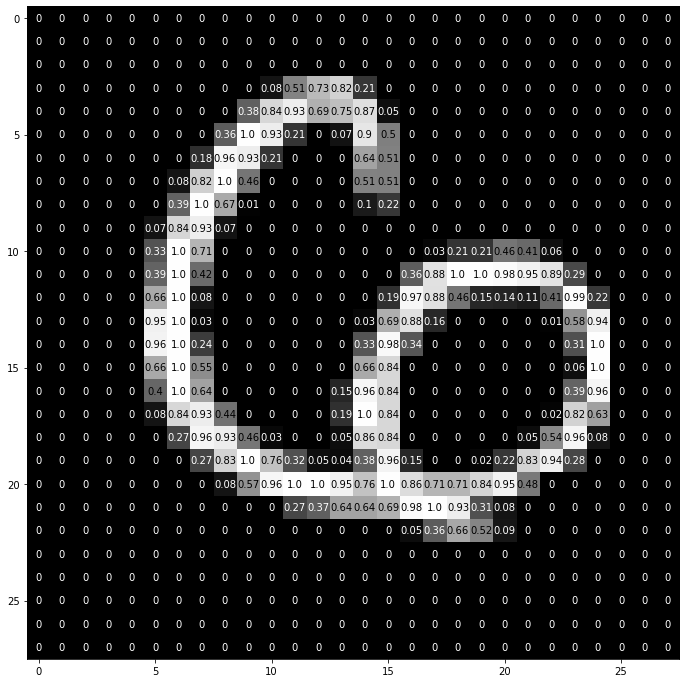

In [ ]:
from pathlib import WindowsPath #시스템 경로 라이브러리.

idx = 7 #7번째 이미지 선택.
img = np.squeeze(images[idx].numpy()) #7번째 이미지를 조물조물 하겠다.

fig = plt.figure(figsize = (12,12)) # 12*12크기로 그림 출력하고.
ax = fig.add_subplot(111)  # 1* 1 그리드에 첫번째 subplot을 추가.
ax.imshow(img, cmap = 'gray')

width, height = img.shape

thresh = img.max() / 2.5 ## 이미지 최댓값을 2.5로 나눈 것.

for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0 ## round는 반올림. img[x][y] 값이 0 아니면, 소수점 둘째자리까지 반올림. 0이면 0으로 표시.
        ax.annotate(str(val), xy = (y,x), #annotate써서 각 위치에 텍스트 표시.
                    horizontalalignment = 'center', # 위치 지정
                    verticalalignment = 'center', # 위치 지정
                    color = 'white' if img[x][y] < thresh else 'black') #img값이 thresh보다 작다면, 'white', 아님 'black'